# NUAGE COMPTA ET LA FACTURE S'ANALYSA
# Application du modèle

## 0. Import des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras import metrics
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import os
import pickle
import cv2
import imutils
from imutils.contours import sort_contours

from src import fonctions

Using TensorFlow backend.


## 1. Chargement du modèle

In [2]:
# model = pickle.load(open("mon_model.h5","rb"))
model = load_model("data/model.h5")


## 2. TEST 1 ---> 1 image (coupée via photoshop)

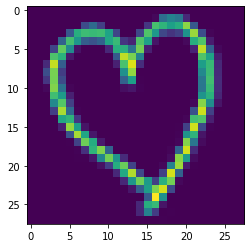

In [3]:
choix = r"assets\COEUR-thomas.png"
test_image = image.load_img(choix, target_size = (28,28), grayscale = True)
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

In [4]:
resultat = model.predict(test_image)
resultat = fonctions.get_result(resultat)
print(f"La lettre correspondante est: {resultat}")

La lettre correspondante est: ♡


## 3. TEST 2 ---> image d'entrainement " FORMATION DATA IA <3 "

In [5]:
imagePath = 'assets\imagedentrainement.jpeg'

In [6]:
### Je charge mon image d'entrée à partir de la variable "imagePath" puis je la convertie en niveau de gris ###

image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray,5)

In [7]:
### Détection des contours ###

blurred = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
edged = cv2.Canny(blurred, 170, 255)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

In [8]:
### Initialisation de la liste des contours ###

chars = []

In [9]:
### Détection des ROI ###

for c in cnts:
    
    (x, y, w, h) = cv2.boundingRect(c)
    
    if (w >= 5) and (h >= 15):
        
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        
        if tW > tH:
            thresh = imutils.resize(thresh, width=28)
        else:
            thresh = imutils.resize(thresh, height=28)

        padded = cv2.copyMakeBorder(thresh, top=4, bottom=4,
                                    left=4, right=4, borderType=cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
        
        padded = cv2.resize(padded, (28, 28))
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        ### Mise à jour notre liste de caractères qui seront OCR ###
        chars.append((padded, (x, y, w, h)))

In [10]:
### Extraction des emplacements de la boîte englobante et des caractères remplis ###
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")


### OCR les caractères à l'aide de notre modèle de reconnaissance de l'écriture manuscrite ###

preds = model.predict(chars)

In [11]:
### On définie la liste des noms des "étiquettes" (ABCDEFG...)
labelNames = "ABCDEFGHIJKLMNOPQRSTUVWXYZ♡"
labelNames = [l for l in labelNames]

In [12]:
### Boucle sur les prédictions et les emplacements de la boîte englobante ensemble ###

for (pred, (x, y, w, h)) in zip(preds, boxes):
    ### trouver l'index de l'étiquette avec le plus grand correspondant probabilité, puis extrayez la probabilité et l'étiquette ###
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # Dessin de la prediction sur l'image ###
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

[INFO] F - 99.34%
[INFO] O - 69.29%
[INFO] R - 98.38%
[INFO] M - 98.47%
[INFO] A - 63.42%
[INFO] T - 99.16%
[INFO] S - 38.15%
[INFO] Q - 47.48%
[INFO] M - 96.79%
[INFO] D - 60.70%
[INFO] A - 97.25%
[INFO] T - 97.15%
[INFO] ♡ - 96.96%
[INFO] A - 89.33%
[INFO] X - 47.21%
[INFO] A - 97.71%


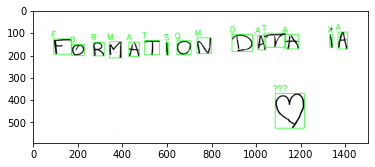

In [13]:
### Montre l'image ###
plt.imshow(image)